In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [52]:
# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


In [53]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
print(df_encoded.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Male  gender_Other  smoking_history_current  \
0         0            0             0                        0   
1         0            0             0                        0   
2         0            1             0                        0   
3         0            0             0                        1   
4         0            1             0                        1   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0             

In [54]:
testDF = df_encoded
testDF = testDF.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
# numerical_columns = ['age','bmi','HbA1c_level','blood_glucose_level']
# boolean_columns = list(set(x_unscaled.columns) - set(numerical_columns))
boolean_columns = x_unscaled.select_dtypes(include=bool).columns

scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if CUDA is available and print the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Encoder model with reduced complexity and dropout
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Define the Decoder model with reduced complexity and dropout
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(x)


# model without dropout
# class Encoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, encoding_dim)
#         )

#     def forward(self, x):
#         return self.encoder(x)

# # Decoder without dropout
# class Decoder(nn.Module):
#     def __init__(self, encoding_dim, input_dim):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, input_dim)
#         )

#     def forward(self, x):
#         return self.decoder(x)
    


# Load and preprocess data
# Assuming x_train, x_test, y_train, and y_test are already defined and normalized
x_train_scaled = x_train.values if isinstance(x_train, pd.DataFrame) else x_train
x_val_scaled = x_val.values if isinstance(x_val, pd.DataFrame) else x_val
x_test_scaled = x_test.values if isinstance(x_test, pd.DataFrame) else x_test

# Define input dimensions
input_dim = x_train_scaled.shape[1]

# Model file paths
encoder_model_file = './models/encoder2.pth'
decoder_model_file = './models/decoder2.pth'

# Hyperparameters
encoding_dim = 8
learning_rate = 0.001
epochs = 1000
batch_size = 64
patience = 10

# Check if the model files exist
if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
    print("Model files exist. Loading the models...")
    encoder = Encoder(input_dim, encoding_dim).to(device)
    decoder = Decoder(encoding_dim, input_dim).to(device)
    encoder.load_state_dict(torch.load(encoder_model_file))
    decoder.load_state_dict(torch.load(decoder_model_file))
else:
    print("Model files do not exist. Training new models...")

    # Initialize the encoder and decoder models
    encoder = Encoder(input_dim, encoding_dim).to(device)
    decoder = Decoder(encoding_dim, input_dim).to(device)
    optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
    optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Track training loss
    encoder_losses = []
    decoder_losses = []

    # Train the Encoder separately
    encoder.train()
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        dataloader = DataLoader(TensorDataset(torch.tensor(x_train_scaled, dtype=torch.float32).to(device), torch.tensor(x_train_scaled, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
        for i, (batch_X, _) in enumerate(dataloader):
            batch_X = batch_X.to(device)
            optimizer_encoder.zero_grad()
            encoded = encoder(batch_X)
            # Pass the encoded output through the decoder
            decoded = decoder(encoded)
            # Calculate loss between decoder output and original input
            loss = criterion(decoded, batch_X)
            loss.backward()
            
            optimizer_encoder.step()
            optimizer_encoder.zero_grad()
            
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        encoder_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

        # Validation loss
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            val_encoded = encoder(torch.tensor(x_val_scaled, dtype=torch.float32).to(device))
            val_decoded = decoder(val_encoded)
            val_loss = criterion(val_decoded, torch.tensor(x_val_scaled, dtype=torch.float32).to(device)).item()
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Train the Decoder separately
    encoded_train = encoder(torch.tensor(x_train_scaled, dtype=torch.float32).to(device)).detach()
    decoder.train()
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(x_train_scaled, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
        for i, (batch_X, batch_y) in enumerate(dataloader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer_decoder.zero_grad()
            outputs = decoder(batch_X)
            # Calculate loss between decoder output and original input
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            optimizer_decoder.step()
            optimizer_decoder.zero_grad()
            
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        decoder_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

        # Validation loss
        decoder.eval()
        with torch.no_grad():
            val_outputs = decoder(encoded_train)
            val_loss = criterion(val_outputs, torch.tensor(x_train_scaled, dtype=torch.float32).to(device)).item()
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Save the trained models
    os.makedirs('./models', exist_ok=True)
    torch.save(encoder.state_dict(), encoder_model_file)
    torch.save(decoder.state_dict(), decoder_model_file)
    print("Models trained and saved.")

# Combine Encoder and Decoder to form the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoder, decoder).to(device)
autoencoder.eval()

# Calculate reconstruction error on the test set
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(x_test_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# Calculate Reconstruction Error Percentage
reconstruction_error_percentage = (
    np.mean(np.abs(x_test_scaled - reconstructed_test) / (np.abs(x_test_scaled) + 1e-8), axis=1) * 100
)  # Prevent division by zero using 1e-8

reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)

def calculate_error_for_index(index):
    return np.mean(np.abs(x_test_scaled[index] - reconstructed_test[index]) / (np.abs(x_test_scaled[index]) + 1e-8)) * 100

greater_than_mean = 0
less_than_20 = 0
for i in range(x_test_scaled.shape[0]):
    if (calculate_error_for_index(i) > reconstruction_error_percentage_mean):
        greater_than_mean += 1
    elif (calculate_error_for_index(i) < 25):
        less_than_20 += 1
        
print("Number of outliers: ", greater_than_mean)
print("Number of inliers: ", less_than_20)
print("Error percentage mean: ", reconstruction_error_percentage_mean)


# calcualting the mse and mae
mse = np.mean((x_test_scaled - reconstructed_test) ** 2)
mae = np.mean(np.abs(x_test_scaled - reconstructed_test))

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

Using device: cuda
Model files exist. Loading the models...


C:\Users\ROG\AppData\Local\Temp/ipykernel_4552/1772615170.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_model_file))
C:\Us

Number of outliers:  2033
Number of inliers:  1395
Error percentage mean:  2159.25102976472
Mean Squared Error:  0.03585285757891554
Mean Absolute Error:  0.10476475801584073


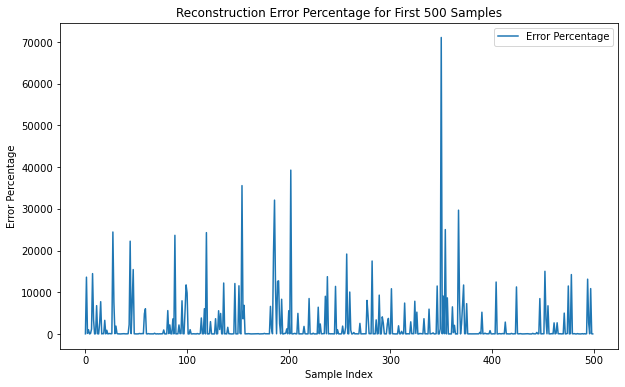

Number of samples with error percentage over 500%: 121
Number of samples with error percentage over 1000%: 116
Number of samples with error percentage over 2500%: 95


In [56]:
#error percent array for first 100 samples
error_percent_array = []
for i in range(500):
    error_percent_array.append(calculate_error_for_index(i))

plt.figure(figsize=(10, 6))
plt.plot(error_percent_array, label='Error Percentage')
plt.xlabel('Sample Index')
plt.ylabel('Error Percentage')
plt.title('Reconstruction Error Percentage for First 500 Samples')
plt.legend()
plt.show()

# number of samples over 500%
num_samples_over_500 = np.sum(np.array(error_percent_array) > 500)
print(f"Number of samples with error percentage over 500%: {num_samples_over_500}")

num_samples_over_1000 = np.sum(np.array(error_percent_array) > 1000)
print(f"Number of samples with error percentage over 1000%: {num_samples_over_1000}")

num_samples_over_2500 = np.sum(np.array(error_percent_array) > 2500)
print(f"Number of samples with error percentage over 2500%: {num_samples_over_2500}")



<span style="color: yellow; font-size: 36px;">Using the error percentage might not be the best evaluation metric, as some features in the training data have very small values, and a slight absolute error can result in a high error percentage</span>

<span style="color: yellow; font-size: 36px;">Instead, it is better to focus on other metrics such as MSE and MAE</span>

In [57]:
def calculate_absolute_error_for_index(index):
    return np.mean(np.abs(x_test_scaled[index] - reconstructed_test[index]))

print("Mean Absolute Error: ", mae)
count = 0 
for i in range(x_test_scaled.shape[0]):
    if (calculate_absolute_error_for_index(i) > mae):
        count += 1

print("Number of samples with absolute error greater than MAE: ", count)
print("test shape: ", x_test_scaled.shape[0])

Mean Absolute Error:  0.10476475801584073
Number of samples with absolute error greater than MAE:  3207
test shape:  10000
